<font size="5">Prendo i dati dal WEB</font>

In [1]:
import requests as rq
from bs4 import BeautifulSoup
import html5lib
import lxml
import selenium
import time
from selenium import webdriver
import pandas as pd

In [2]:
#Settings
inizio="20241202" #Start one day previous to the one you want to start from
fine="20241211"
Crypto_Alt_Season="BTC" #Crypto that i want to use as an indicator for my ALT season (default BTC)
Crypto_to_invest="ETH" #Crypto that i want to buy and seel
Metric="Price" #Metric of my Alt Season
N_Crypto=50 #Number of Crypto i take into consideration for my ALT season (max 200)


In [3]:
#Function to get every date from a range
def Print_every_day(start,end):
    date=[]

    month31=[1,3,5,7,8,10,12]
    month30=[4,6,9,11]

    year=int(start[:4])
    month=int(start[4:6])
    day=int(start[6:8])
    
    year_end=int(end[:4])
    moth_end=int(end[4:6])
    day_end=int(end[6:8])

    while (year<year_end) or (year==year_end and month<moth_end) or (year==year_end and month==moth_end and day<day_end):


        if year%4==0:#Check if it is a leap year

            if month<12:#Check if I'm at the end of the month

                if (month in month31): 
                    if day<31:
                        day+=1
                    else:
                        month+=1
                        day=1

                elif (month in month30): 
                    if day<30:
                        day+=1
                    else:
                        month+=1
                        day=1

                elif day<29: #February
                    day+=1
                else:
                    month+=1
                    day=1
            else:
                if day<31:
                    day+=1
                else:
                    year+=1
                    month=1
                    day=1
        else:
            if month<12:

                if (month in month31): 
                    if day<31:
                        day+=1
                    else:
                        month+=1
                        day=1

                elif (month in month30): 
                    if day<30:
                        day+=1
                    else:
                        month+=1
                        day=1

                elif day<28: 
                    day+=1
                else:
                    month+=1
                    day=1
            else:
                if day<31:
                    day+=1
                else:
                    year+=1
                    month=1
                    day=1


        if day<10: #Check if I need to add a 0 in front of the number
            day=str(day)
            day="0"+day
        else:
            day=str(day)

        if month<10: #Check if I need to add a 0 in front of the month
            month=str(month)
            month="0"+month
        else:
            month=str(month)
        
        year=str(year)

        date.append(year+month+day) #Add my date to the date list
        #Reconvert in int so that i can do operation on them
        year=int(year)
        month=int(month)
        day=int(day)
    
    return date

In [ ]:
#Take the Data from the internet

sleep_for=1 
sleep=1
Date=Print_every_day(inizio,fine) 

#Cycle every page untill i get to the end
for j in range(len(Date)):
    
    url=f"https://coinmarketcap.com/historical/{Date[j]}/"
    driver=webdriver.Chrome()
    driver.get(url)
    time.sleep(sleep_for)
    scroll_height = driver.execute_script("return document.body.scrollHeight;")
    screen_height = driver.execute_script("return window.screen.height;") 

    
    i=1
    while True:
        
        step=screen_height * i
        driver.execute_script(f"window.scrollTo(0, {step});")
        i += 1
        time.sleep(sleep)

        
        if step> scroll_height:
            break

    #Extract data from the html
    html = driver.page_source 
    driver.quit()
    soup=BeautifulSoup(html,"html.parser")
    righe=soup.find_all("tr",class_="cmc-table-row")#Load all row of the table


    Rank=[]
    Ticket=[]
    Market_Cap=[]
    Vol=[]
    Price=[]
    Supply=[]
    Change1h=[]
    Change24h=[]
    Change7d=[]
    Historical_Data_1w=pd.DataFrame()



    #Take all data that i need
    for x in righe:
        num=x.find("td",class_="cmc-table__cell cmc-table__cell--sticky cmc-table__cell--sortable cmc-table__cell--left cmc-table__cell--sort-by__rank")
        Simbolo=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--left cmc-table__cell--sort-by__symbol")
        MC=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__market-cap")
        Volume=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__volume-24-h")
        PriceData=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__price")
        Circulating_Supply=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__circulating-supply")
        Change_1h=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-1-h")
        Change_24h=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-24-h")
        Change_7d=x.find("td",class_="cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-7-d")

        num=num.text
        if "--" in num:
            num=num.replace("--","")
            Rank.append(int(num))
        else:
            Rank.append(int(num))
        
        Simbolo=Simbolo.text
        if "--" in Simbolo:
            Simbolo=Simbolo.replace("--","")
            Ticket.append(Simbolo)
        else:
            Ticket.append(Simbolo)

        MC=MC.text
        MC = MC.replace(',', '')
        MC = MC.replace('$', '')
        if "--" in MC:
            MC=MC.replace("--","")
            Market_Cap.append(MC)
        else:
            Market_Cap.append(float(MC))
        
        if Volume!=None:
            Volume=Volume.text
            Volume = Volume.replace(',', '')
            Volume = Volume.replace('$', '')
            if "<" in Volume:
                Volume = Volume.replace('<', '')
            if ">" in Volume:
                Volume = Volume.replace('>', '')
            if "--" in Volume:
                Volume=Volume.replace("--","")
                Vol.append(Volume)
            else:
                Vol.append(float(Volume))
        else:
            Vol.append(None)

        PriceData=PriceData.text
        PriceData = PriceData.replace(',', '')
        PriceData = PriceData.replace('$', '')
        if "--" in PriceData:
            PriceData=PriceData.replace("--","")
            Price.append(PriceData)
        else:
            Price.append(float(PriceData))

        Circulating_Supply=Circulating_Supply.text
        Circulating_Supply = Circulating_Supply.replace('.', '')
        
        Circulating_Supply = Circulating_Supply.replace('*', '')
        Circulating_Supply = Circulating_Supply.replace(Simbolo, '')
        if "--" in Circulating_Supply:
            Circulating_Supply=Circulating_Supply.replace("--","")
            Supply.append(Circulating_Supply)
        else:
            Supply.append(float(Circulating_Supply))


        Change_1h=Change_1h.text
        Change_1h = Change_1h.replace(',', '.')
        Change_1h = Change_1h.replace('%', '')
        if "<" in Change_1h:
            Change_1h = Change_1h.replace('<', '')
        if ">" in Change_1h:
            Change_1h = Change_1h.replace('>', '')
        if "--" in Change_1h:
            Change_1h=Change_1h.replace("--","")
            Change1h.append(Change_1h)
        else:
            if len(Change_1h)>=8:#To account for changes 1.046,36% so that i can format them
                Change_1h=Change_1h.replace(".","")
                Change_1h=(float(Change_1h))/100 #Now it would be something like 104636, so i divide by 100 to get the original value
                Change1h.append(Change_1h)
            else:
                Change1h.append(float(Change_1h))

        Change_24h=Change_24h.text
        Change_24h = Change_24h.replace(',', '.')
        Change_24h = Change_24h.replace('%', "")
        if "<" in Change_24h:
            Change_24h = Change_24h.replace('<', '')
        if ">" in Change_24h:
            Change_24h = Change_24h.replace('>', '')
        if "--" in Change_24h:
            Change_24h = Change_24h.replace('--', "")
            Change24h.append(Change_24h)
        else:
            if len(Change_24h)>=8:
                Change_24h=Change_24h.replace(".","")
                Change_24h=(float(Change_24h))/100
                Change24h.append(Change_24h)
            else:
                Change24h.append(float(Change_24h))
  
        Change_7d=Change_7d.text
        Change_7d = Change_7d.replace(',', '.')
        Change_7d = Change_7d.replace('%', '')
        if "<" in Change_7d:
            Change_7d = Change_7d.replace('<', "")
        if ">" in Change_7d:
            Change_7d = Change_7d.replace('>', '')
        if "--" in Change_7d:
            Change_7d = Change_7d.replace('--', "")
            Change7d.append(Change_7d)
        else:
            if len(Change_7d)>=8:
                Change_7d=Change_7d.replace(".","")
                Change_7d=(float(Change_7d))/100 
                Change7d.append(Change_7d)
            else:
                Change7d.append(float(Change_7d))
            
        #Put everything inside a dataframe, and then inside a csv
        Historical_Data_1w=pd.DataFrame({"Rank":Rank,"Symbol":Ticket,"Market Cap":Market_Cap,"Volume":Vol,"Prezzo":Price,  
                                 "Circulating":Supply,"1h Variation":Change1h,"24h Variation":Change24h,"7d Variation":Change7d})
        Historical_Data_1w.to_csv(f"Hystorical Data CoinMarketCap/{Date[j]}.csv") 


<font size="5">Create the List of Assets that i need to eliminate from my ALT season index</font>

In [5]:

url="https://coinmarketcap.com/view/stablecoin/"
Information=rq.get(url)

soup=BeautifulSoup(Information.content,"html.parser")


rw1=soup.find_all("tr",style="cursor:pointer")
rw2=soup.find_all("tr",class_="sc-240ce903-0 iPeVVh")

Ticket=[]


for x in rw1:
    Symbol=x.find("div",class_="sc-e8147118-3 jcakMR")#sc-1c5f2868-3 hHWqgz was the old class_
    
    Ticket.append(Symbol.text)

for x in rw2:
    
    Symbol=x.find("span",class_="crypto-symbol") #Questo è quello giusto
    Ticket.append(Symbol.text)

Stable_Coin=pd.Series(Ticket)
Stable_Coin.to_csv("C:/Users/Massimo/Desktop/Python/Script/Alt Season Index/Crypto Type List/Stable Coin List.csv")

In [6]:
sleep=1
#Take the data of asset-backed crypto
url="https://www.coingecko.com/en/categories/asset-backed-tokens"

driver=webdriver.Chrome()
driver.get(url)

scroll_height = driver.execute_script("return document.body.scrollHeight;")
screen_height = driver.execute_script("return window.screen.height;") 


i=1
while True:
    
    step=screen_height * i
    driver.execute_script(f"window.scrollTo(0, {step});")
    i += 1
    time.sleep(sleep)

    
    if step> scroll_height:
        break

    

html = driver.page_source 
driver.quit()


soup=BeautifulSoup(html,"html.parser")


righe=soup.find_all("tr",class_="hover:tw-bg-gray-50 tw-bg-white dark:tw-bg-moon-900 hover:dark:tw-bg-moon-800 tw-text-sm")


Ticket=[]

#Take every data i need from each row of the table
for x in righe:
    Simbolo=x.find("div",class_="tw-block 2lg:tw-inline tw-text-xs tw-leading-4 tw-text-gray-500 dark:tw-text-moon-200 tw-font-medium")
    Simbolo=Simbolo.text

    MarketCap=x.find("td",class_="tw-text-end tw-px-1 tw-py-2.5 2lg:tw-p-2.5 tw-bg-inherit tw-text-gray-900 dark:tw-text-moon-50")
    

    Simbolo_Finale=""
    for ln in range(len(Simbolo)):
        
        dummy=""

        if ln>2 and ln<range(len(Simbolo))[-1] and Simbolo[ln]!="":
            dummy = Simbolo[ln]

        Simbolo_Finale+=dummy
    
    Ticket.append(Simbolo_Finale)

Ticket=Ticket[:32] #Take only the first 32, since the rest dont even have a Market Cap, i know that it is a bad way of solving this problem, but it works just fine 
print(Ticket)


Assets_Backed_Token=pd.Series(Ticket)
Assets_Backed_Token.to_csv("Crypto Type List/Asset Backed Token List.csv")

<font size="5">Calculate the Alt Season</font>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mt

In [8]:
#Per prima cosa mi trovo la lista di tutte le crypto che mi sono state in top, nella mia serie di dati
def Find_Unique_Crypto(start,end,Number_Of_Crypto):
    Date=Print_every_day(start,end)
    Crypto_ticket=pd.Series()
    for d in Date:
        Data_Extracted=pd.read_csv(f"Hystorical Data CoinMarketCap/{d}.csv").drop("Unnamed: 0",axis=1)
        Crypto_ticket=pd.concat([Crypto_ticket,Data_Extracted["Symbol"][:Number_Of_Crypto]],ignore_index=True)
        
    
    Crypto_ticket=list(set(Crypto_ticket)) #I make it a set so that it has only unique value, then i make it a list in case i need to do operations on it
    Crypto_ticket=pd.Series(Crypto_ticket)

    Crypto_ticket.drop(Crypto_ticket.index[pd.isna(Crypto_ticket)==True],inplace=True) #Delete nan values
    
    return Crypto_ticket

In [9]:

Date=Print_every_day(inizio,fine)
Crypto_ticket=Find_Unique_Crypto("20130427",fine,N_Crypto)#I put a fixed start so that i can easily concatenate my dataset
Data_R=Date
print(Data_R[-1])

Empty_Data=['20131031', '20140107', '20140122', '20140329', '20141002', '20141212', '20150110', '20150228', '20150918', '20170710', '20210407', '20210408']

try:
    for ed in Empty_Data:
        Data_R.remove(ed)
    print(Data_R)
except:
    "" 


#Load the list of Stable Coin and Asset Backed Crypto since i dont want to use them when calculating the ALT season
Stable_Coin=pd.read_csv("Stable Coin and Asset Backed Token/Stable Coin List.csv").drop("Unnamed: 0",axis=1)
Asset_Backed_Crypto=pd.read_csv("Stable Coin and Asset Backed Token/Asset Backed Token List.csv").drop("Unnamed: 0",axis=1)



Historical_Data_Of_Interest=pd.DataFrame()



for t in Crypto_ticket:
    Data_Of_Interest=[]
    N_Crypto=50
    Break_out=False


    for d in Data_R:

        if (Stable_Coin.index[Stable_Coin["0"]==t].size>0) or (Asset_Backed_Crypto.index[Asset_Backed_Crypto["0"]==t].size>0): 
            Break_out=True
            break
        
            
        Data_Extracted=pd.read_csv(f"Hystorical Data CoinMarketCap/{d}.csv").drop("Unnamed: 0",axis=1)


        
        

        if t in list(Data_Extracted["Symbol"]):
            ser=Data_Extracted[Metric].iloc[Data_Extracted.index[Data_Extracted["Symbol"]==t]]#Take the Metric of the crypto I'm checking
            ser=float(ser.iloc[0])
            
            Data_Of_Interest.append(ser)
        else:
            Data_Of_Interest.append(None)
        
    #Concatenate the dataset
    if Break_out==False:
        Historical_Data_Of_Interest_Dummy=pd.DataFrame({t:Data_Of_Interest},index=Data_R)
        Historical_Data_Of_Interest=pd.concat([Historical_Data_Of_Interest,Historical_Data_Of_Interest_Dummy],axis=1)

#Order them in alphabetical order in order to concatenate them with the dataset
Historical_Data_Of_Interest.sort_index(axis=1,inplace=True)

Old_price=pd.read_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Metric}.csv",index_col="Unnamed: 0") 
#Concat wit the old dataframe
Historical_Data=pd.concat([Old_price,Historical_Data_Of_Interest])
#Put inside a csv
Historical_Data.to_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Metric}.csv")

20241211
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--
--BREAK--


In [11]:
#Apply the pct change and put inside a csv
shift=90
Historical_Data=Historical_Data.pct_change(periods=shift)*100
Historical_Data.to_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Metric}_pct_change.csv")

In [12]:
#Create a table that for each days, orders the name of the cryptos in ascending order by the metric of interest
Stable_Coin=pd.read_csv("Stable Coin and Asset Backed Token/Stable Coin List.csv").drop("Unnamed: 0",axis=1)
Asset_Backed_Crypto=pd.read_csv("Stable Coin and Asset Backed Token/Asset Backed Token List.csv").drop("Unnamed: 0",axis=1)


All_Date=Print_every_day("20130428",fine)
Empty_Data=['20131031', '20140107', '20140122', '20140329', '20141002', '20141212', '20150110', '20150228', '20150918', '20170710', '20210407', '20210408']
try:
    for ed in Empty_Data:
        All_Date.remove(ed)
except:
    "" 

Historical_Data.index=All_Date 




Historical_Data_Of_Interest_ordered_Dummy=pd.read_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Metric}_pct_change.csv").drop("Unnamed: 0",axis=1)
Historical_Data_Of_Interest_ordered_Dummy.index=Data_R #Put the index name as the one of the Data


Historical_Data_Of_Interest_ordered_Ticket=pd.DataFrame()


for d in All_Date:

    Data_Extracted=pd.read_csv(f"Hystorical Data CoinMarketCap/{d}.csv").drop("Unnamed: 0",axis=1)

    Data_Extracted=Data_Extracted["Symnbol"]
    Data_Extracted=[x for x in Data_Extracted.values if (x not in Stable_Coin.values and x not in Asset_Backed_Crypto.values)]
    
    Data_Extracted_TOP=Data_Extracted[:N_Crypto]


    H_I_D_O_I_key_sort_TOP=[]
    H_I_D_O_I_dict=Historical_Data.loc[d]
    H_I_D_O_I_dict=dict(H_I_D_O_I_dict) 
    H_I_D_O_I_keys=list(H_I_D_O_I_dict.keys()) 
    H_I_D_O_I_values=list(H_I_D_O_I_dict.values()) 
    
    
    H_I_D_O_I_value_index_ordered=np.argsort(H_I_D_O_I_values) 
    H_I_D_O_I_dict_sort={H_I_D_O_I_keys[i]: H_I_D_O_I_values[i] for i in H_I_D_O_I_value_index_ordered} 

    
    H_I_D_O_I_key_sort=list(H_I_D_O_I_dict_sort.keys())
    
    H_I_D_O_I_key_sort_TOP=[x for x in H_I_D_O_I_key_sort if x in Data_Extracted_TOP]

    
    Historical_Data_Of_Interest_ordered_Ticket_Dummy=pd.DataFrame(data=H_I_D_O_I_key_sort_TOP,columns=[d])
    Historical_Data_Of_Interest_ordered_Ticket=pd.concat([Historical_Data_Of_Interest_ordered_Ticket,Historical_Data_Of_Interest_ordered_Ticket_Dummy],axis=1)



#Put inside a CSV
Historical_Data_Of_Interest_ordered_Ticket.to_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Metric}_pct_change_ordered_ticket.csv")

In [14]:
#I load the data of the variation of tickets during time, and then i find the variation of the ticket i want
H_D_O_I_final=pd.read_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Metric}_pct_change_ordered_ticket.csv").drop("Unnamed: 0",axis=1)



value_altSeason=[]
Dummy_to_use={}
for d in H_D_O_I_final.columns:
    
    if len(H_D_O_I_final[d].index[H_D_O_I_final[d]==Crypto_Alt_Season])!=0:#Make sure that in that day there actually is the ticket i'm searching
        value_altSeason.append(H_D_O_I_final[d].index[H_D_O_I_final[d]==Crypto_Alt_Season][0])
        Dummy_to_use[d]=value_altSeason[-1]
    else:
        value_altSeason.append(None)
        Dummy_to_use[d]=value_altSeason[-1]
Dummy_to_use=pd.Series(Dummy_to_use)




#I put the value on a scale from 1 to 100
Alt_Season=Dummy_to_use*100/len(H_D_O_I_final)#This might not be the best method, but that's the one i'm using



#Since they are ordered in ascending order, if BTC has a higher return, it will be at the bottom, 
#But i want that when BTC is at the bottom it should be BCT season (so BTC is performing well)
Alt_Season=Alt_Season.apply(lambda x: mt.sqrt((float(x)-100)**2)) #A more mathematical method to get abs, instead of just using the function


#Put inside a csv
Alt_Season.to_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Crypto_Alt_Season}_{Metric}_Alt_Season.csv")

Attuale il valore della BTC ALT season è:  66.0


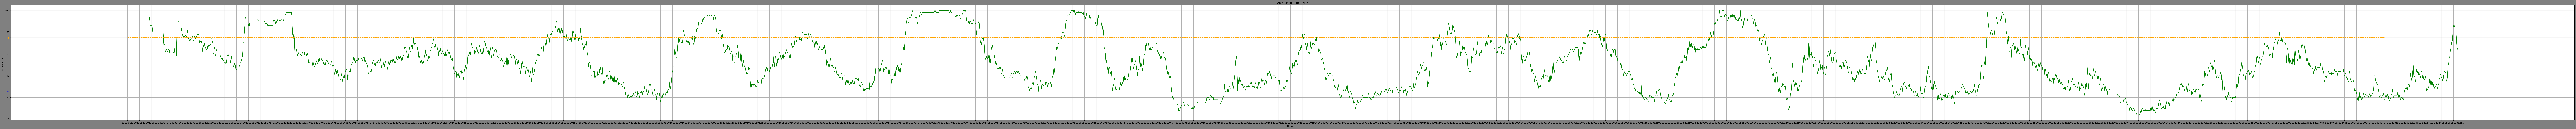

In [15]:
#Take the Data to plot them

Alt_Season_Index_ToPrint=Alt_Season
Label=[]
for ind in range(0,len(Alt_Season_Index_ToPrint),22):
    Label.append(Alt_Season.index[ind])

Label.append(Alt_Season.index[-1])

Label_Restricted=Label[-20:]

yticks=[0,20,25,40,60,75,80,100]
fig,ax =plt.subplots(1,1,figsize=(200,9),sharex=True,facecolor="gray",dpi=200,sharey=False)


ax.plot(Alt_Season.index,Alt_Season,color="green")
ax.set(title="Alt Season Index Price",xlabel="Date (1g)",ylabel=f"Position {Crypto_Alt_Season}")
ax.set_yticks(ticks=yticks)
ax.set_xticks(ticks=Label)
ax.get_yticklabels()[2].set_color("blue")
ax.get_yticklabels()[5].set_color("orange")
ax.hlines(y=75,color="orange",linestyles="dashed",xmin=1,xmax=4099)
ax.hlines(y=25,color="blue",linestyles="dashed",xmin=1,xmax=4099)
ax.grid()

print("The Current Value of the ALT season is: ",Alt_Season[-1])
plt.show()

<font size="5">Buy and Sell (and example on how this code might be used)</font>

In [16]:
Alt_Season_Index_Prezzo=pd.read_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Crypto_to_invest}_{Metric}_Alt_Season.csv",index_col="Unnamed: 0")
BTC_Alt_Season_Index_Prezzo=pd.read_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/BTC_{Metric}_Alt_Season.csv",index_col="Unnamed: 0")
Price=pd.read_csv(f"Alt_Season_With_{N_Crypto}_Cryptos/{Metric}.csv",index_col="Unnamed: 0")
Price.index=Price.index.astype("string")
Alt_Season_Index_Prezzo.index=Alt_Season_Index_Prezzo.index.astype("string")
BTC_Alt_Season_Index_Prezzo.index=BTC_Alt_Season_Index_Prezzo.index.astype("string")

In [17]:
#Simulate a strategy where i Buy and Sell ETH when in between BTC and ALT season
Capital=1000
Fees=0.001#In percentage
First_Time=False
Crypto_Hold=0
All_Capital=[]
date_label=[]
BTC_value_buy=[] 
BTC_value_sell=[]
Range=-300 #It goes way back than just 300 days

Starting_date=0
count_30=0 #It check if 30 days have passed or not, so that i can periodic capital
Capital_to_add=100
Added=0 
for d in BTC_Alt_Season_Index_Prezzo.index[Range:]:
    count_30+=1 
    

    #Buy
    if (BTC_Alt_Season_Index_Prezzo["0"].loc[d]<75 and BTC_Alt_Season_Index_Prezzo["0"].loc[d]>25) and Capital!=0 and (mt.isnan(Price[Crypto_to_invest].loc[d])==False):
        
        Prezzo=Price[Crypto_to_invest].loc[d]
       
        Crypto_Hold=Capital/Prezzo
        
        Crypto_Hold=Crypto_Hold-(Crypto_Hold*Fees)#Simulate fees
        Capital=0
        print("Buy",d)

    #Sell
    if (BTC_Alt_Season_Index_Prezzo["0"].loc[d]>=80 or BTC_Alt_Season_Index_Prezzo["0"].loc[d]<=20) and Crypto_Hold!=0 and (mt.isnan(Price[Crypto_to_invest].loc[d])==False):
        
        Prezzo=Price[Crypto_to_invest].loc[d]
        Capital=Crypto_Hold*Prezzo
        Capital=Capital-(Capital*Fees)#Simulate fees
        Crypto_Hold=0
        All_Capital.append(Capital)
        date_label.append(d)
        print("Sell",d)
    
    
    if Crypto_Hold!=0 and count_30%30==0:
        Added+=1
        Crypto_Hold+=Capital_to_add/Price[Crypto_to_invest].loc[d]-(Capital_to_add/Price[Crypto_to_invest].loc[d]*Fees)
        print("ADD+++++",d)  




#Initialize 2 variable that i use to see how much money i would have made if i just had holded BTC for the same time period
Capital_Holding=1000
Date_since_not_null=Alt_Season_Index_Prezzo.index[(Alt_Season_Index_Prezzo["0"]).isnull()==False]#Find the first non nan date for the crypto i'm buying (usefull for everything except BTC since it has the longest duration out of all cryptos)
First_Price=Price[Crypto_to_invest].loc[Date_since_not_null[Range]]
Last_Price=Price[Crypto_to_invest].loc[BTC_Alt_Season_Index_Prezzo.index[-1]]
Holding=Capital_Holding/First_Price
Holding=Holding-(Holding*Fees)#Simulate Fees
Capital_Holding=Holding*Last_Price
Capital_Holding=Capital_Holding-(Capital_Holding*Fees)#Simulate Fees

print("Capitale Hold",Capital_Holding)#Capitale i would have if i just holded BTC
print("Fine Capitale", All_Capital[-1])#Print the capital i had
print("Guadagno non realizzato",Crypto_Hold*Price[Crypto_to_invest].loc[d]-All_Capital[-1])
print("Totale aggiunto nel tempo", Added*Capital_to_add)


Compro 20240216
ADD+++++ 20240316
ADD+++++ 20240415
ADD+++++ 20240515
Vendo 20240611
Compro 20240616
Vendo 20240617
Compro 20240711
ADD+++++ 20240714
Vendo 20240722
Compro 20240814
Vendo 20240816
Compro 20240824
Vendo 20240826
Compro 20240905
ADD+++++ 20240912
ADD+++++ 20241012
ADD+++++ 20241111
Vendo 20241202
Compro 20241209
ADD+++++ 20241211
Capitale Hold 2293.342801791431
Fine Capitale nan
Guadagno non realizzato nan
Totale aggiunto nel tempo 800


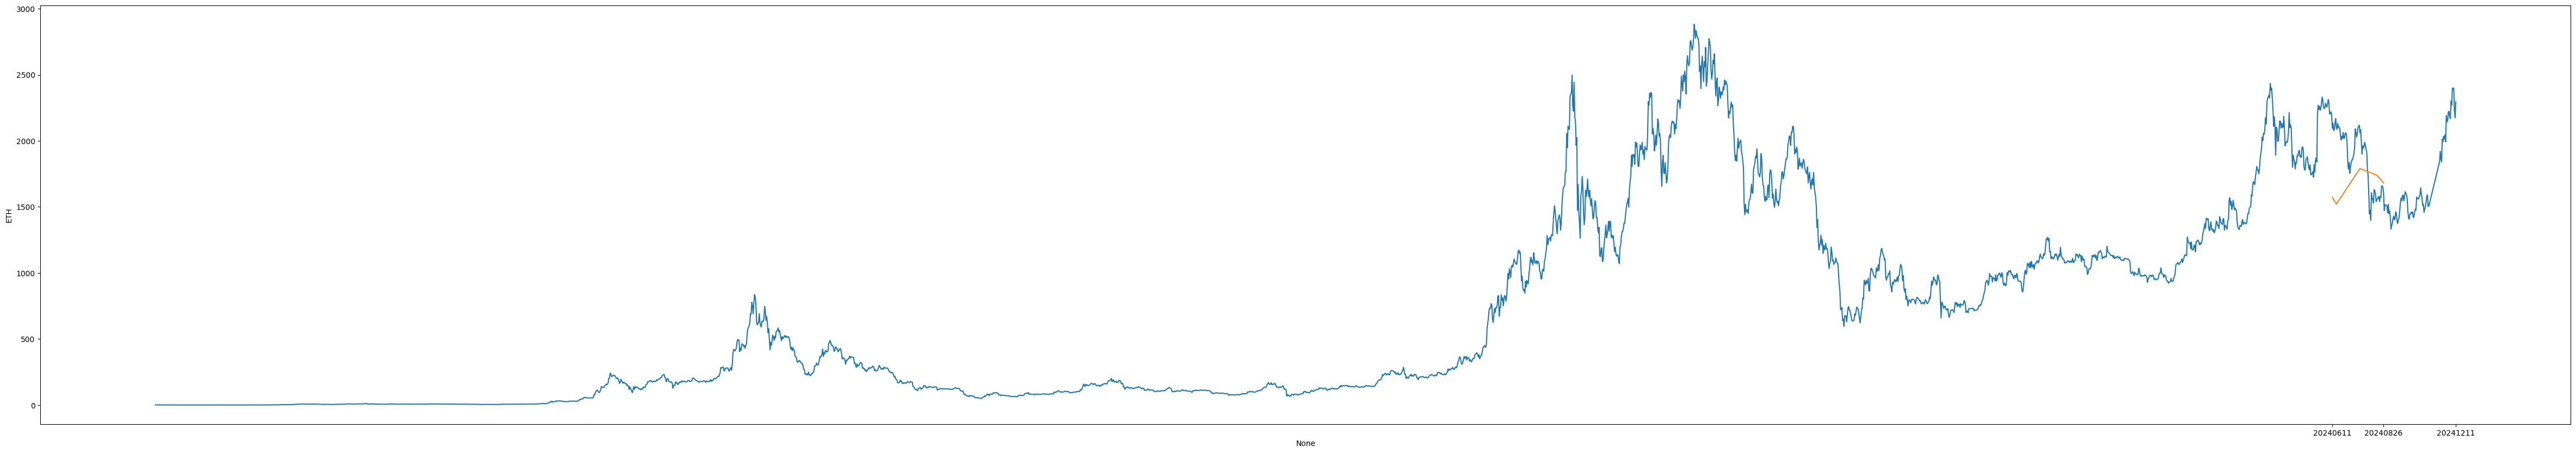

In [18]:
#Output the strategy
fig,ax=plt.subplots(1,1,figsize=(60,10),sharex=True)
sns.lineplot(y=Holding*Price[Crypto_to_invest],x=Price.index,ax=ax)
sns.lineplot(y=All_Capital,x=date_label,ax=ax)
Label_y=[]
for d in range(0,len(date_label),4):
    Label_y.append(date_label[d])
Label_y.append(Price.index[-1])
ax.set_xticks(ticks=Label_y)
plt.show()